In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

## 1 Read dataset & get general sensing


In [2]:
df = pd.read_csv('../../data/bank-full.csv', sep=';')
print(f"Dataset shape: {df.shape}")

df.head(5)

Dataset shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 1.2 check for missing values


In [3]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### Ordinal categorical:

- education

#### Nominal categoricals:

- job
- marital
- default
- housing
- loan
- contact
- poutcome


## 2 Understanding data


In [4]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include='object').columns

print(f"Num of Numerical Features: {len(numerical_features)}")
print(f"Num of Categorical Features: {len(categorical_features)}")

Num of Numerical Features: 7
Num of Categorical Features: 10


### 3 Encode categorical features


In [7]:
categorical_features.drop(['education', 'y'])

Index(['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month',
       'poutcome'],
      dtype='object')

In [10]:
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

df = pd.get_dummies(df, columns=categorical_features.drop(['education', 'y']), drop_first=True)


In [11]:
df.shape

(45211, 41)

In [12]:
X_df = df.drop('y', axis=1)
y_df = df['y']

X_df = X_df.astype(int)

### 4 Feature importance analysis


#### Numerical Feature Importance Analysis (Pearson Correlation Coefficient)


In [13]:
y_df_binary = y_df.map({'no': 0, 'yes': 1})

In [14]:
def calc_pearson_correl(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean) ** 2) * np.sum((y - y_mean) ** 2))
    return numerator / denominator

for feature in numerical_features:
    x = np.array(X_df[feature])
    correl = calc_pearson_correl(x, y_df_binary.values)
    print(f"{feature}: {correl:.2f}")


age: 0.03
balance: 0.05
day: -0.03
duration: 0.39
campaign: -0.07
pdays: 0.10
previous: 0.09


- age: 0.03 → Negligible correlation.
- balance: 0.05 → Negligible correlation.
- day: -0.03 → Negligible correlation.
- duration: 0.39 → Moderate correlation (potentially important feature).
- campaign: -0.07 → Negligible correlation.
- pdays: 0.10 → Weak correlation (may provide some insight).
- previous: 0.09 → Weak correlation (may provide some insight).


#### Categorical Feature Importance Analysis (Chi-Square)


In [15]:
new_categorical_features = df.drop(numerical_features, axis=1)

In [16]:
chi_square_score_map = {}
def calc_chi_square(observed, expected):
    return np.sum((observed - expected) ** 2 / expected)

def chi_square_analysis(categorical_data, target):
    unique_categories = set(categorical_data)
    observed_counts = []
    expected_counts = []
    
    for category in unique_categories:
        category_indices = [i for i, value in enumerate(categorical_data) if value == category] # return the index where the category is found within a series
        observed_count = np.sum(target[category_indices]) # matches where the category feature value coincides with target column, then sum
        total_category_count = len(category_indices) # total number of occurrence for a specific category
        observed_counts.append(observed_count)
        expected_counts.append(total_category_count * np.mean(target)) # expected count = total count * proportion of count
        # in binary 0 and 1, np.mean(target) gives the propotion of 1
    
    observed_counts = np.array(observed_counts)
    expected_counts = np.array(expected_counts)
    return calc_chi_square(observed_counts, expected_counts)

for feature in new_categorical_features:
    x = np.array(df[feature])
    chi_square_value = chi_square_analysis(x, y_df_binary.values)
    chi_square_score_map[feature] = round(chi_square_value, 3)

In [17]:
chi_values = list(chi_square_score_map.values())
mean_chi_value = np.mean(chi_values)
median_chi_value = np.median(chi_values)

print("mean chi value : ", mean_chi_value)
print("median chi value : ", median_chi_value)

for feature, chi_score in chi_square_score_map.items():
    if chi_score > median_chi_value and feature != 'y':
        print(feature)

mean chi value :  1493.2983529411767
median chi value :  101.9445
education
job_blue-collar
job_retired
job_student
marital_married
marital_single
housing_yes
loan_yes
contact_unknown
month_dec
month_mar
month_may
month_oct
month_sep
poutcome_success
poutcome_unknown


### 5 Building k-NN classifier model


## Prepping data & Model training


In [18]:
X_all = X_df.values
y_all = y_df_binary.values

important_features = [
    "duration", 
    "education",
    "job_blue-collar",
    "job_retired",
    "job_student",
    "marital_married",
    "marital_single",
    "housing_yes",
    "loan_yes",
    "contact_unknown",
    "month_dec",
    "month_mar",
    "month_may",
    "month_oct",
    "month_sep",
    "poutcome_success",
    "poutcome_unknown"
]

X_feature_trimmed = X_df[important_features].values

print(X_all.shape)
print(X_feature_trimmed.shape)
print(y_all.shape)

(45211, 40)
(45211, 17)
(45211,)


In [19]:
y_df_binary.value_counts() / len(y_df_binary)
# 88% to 12%, highly imbalanced, use stratified k fold

y
0    0.883015
1    0.116985
Name: count, dtype: float64

In [21]:
# Scale the features for PCA and kNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feature_trimmed)

In [22]:
# Define the kNN model
knn = KNeighborsClassifier(n_neighbors=5, algorithm='auto')

In [ ]:
# Stratified k-fold cross-validation to address imbalance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(knn, X_scaled, y_all, cv=skf, scoring='accuracy')

In [26]:
# Train and evaluate the model
knn.fit(X_scaled, y_all)
y_pred = knn.predict(X_scaled)
report = classification_report(y_all, y_pred)

In [27]:
print(f"Cross-validation accuracy scores: {scores}")
print(f"Mean accuracy: {np.mean(scores):.4f}")
print("\nClassification Report:\n", report)

Cross-validation accuracy scores: [0.89361937 0.89128511 0.89526653 0.89316523 0.88885202]
Mean accuracy: 0.8924

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96     39922
           1       0.73      0.52      0.60      5289

    accuracy                           0.92     45211
   macro avg       0.83      0.75      0.78     45211
weighted avg       0.91      0.92      0.91     45211



### 6 Perform Prediction to evaluate model


In [30]:
df['y_pred'] = y_pred

In [32]:
df['y_binary'] = df['y'].map({'no': 0, 'yes': 1})

In [33]:
df[['y_binary', 'y_pred']]

,y_binary,y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
45206,1,0
45207,1,1
45208,1,1
45209,0,0


In [35]:
df[df['y_binary'] != df['y_pred']][['y_binary', 'y_pred']]

,y_binary,y_pred
61,0,1
83,1,0
129,1,0
168,1,0
224,0,1
...,...,...
45199,0,1
45202,1,0
45204,1,0
45205,1,0


### Finding optimal k


In [ ]:
accuracy_map = {}

for k in range(0, 505, 5):
    if k == 0:
        k += 1
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='auto')
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_val_score(knn, X_scaled, y_all, cv=skf, scoring='accuracy')
    accuracy = round(np.mean(scores), 4)
    accuracy_map[k] = accuracy
    print(f"Processed k value: {k} | Accuracy: {accuracy}")


Processed split value: 2 | Accuracy: 0.8985
Processed split value: 3 | Accuracy: 0.899
Processed split value: 4 | Accuracy: 0.8996
Processed split value: 5 | Accuracy: 0.8999
Processed split value: 6 | Accuracy: 0.8996
Processed split value: 7 | Accuracy: 0.8986
Processed split value: 8 | Accuracy: 0.8991
Processed split value: 9 | Accuracy: 0.8991


In [41]:
accuracy_map

{1: 0.8701,
 5: 0.8923,
 10: 0.8978,
 15: 0.8992,
 20: 0.8986,
 25: 0.8987,
 30: 0.8991,
 35: 0.8994,
 40: 0.8993,
 45: 0.8981,
 50: 0.8991,
 55: 0.8992,
 60: 0.8993,
 65: 0.8994,
 70: 0.8986,
 75: 0.8987,
 80: 0.8981,
 85: 0.8977,
 90: 0.898,
 95: 0.8978,
 100: 0.8975,
 105: 0.8974,
 110: 0.8973,
 115: 0.8974,
 120: 0.8967,
 125: 0.897,
 130: 0.897,
 135: 0.8969,
 140: 0.8968,
 145: 0.8965,
 150: 0.8964,
 155: 0.8964,
 160: 0.8965,
 165: 0.8968,
 170: 0.8962,
 175: 0.8954,
 180: 0.8956,
 185: 0.8958,
 190: 0.8956,
 195: 0.8959,
 200: 0.8956,
 205: 0.8953,
 210: 0.8948,
 215: 0.8955,
 220: 0.8944,
 225: 0.8954,
 230: 0.8957,
 235: 0.8946,
 240: 0.895,
 245: 0.8947,
 250: 0.8947,
 255: 0.8948,
 260: 0.8943,
 265: 0.8946,
 270: 0.8946,
 275: 0.8941,
 280: 0.8937,
 285: 0.8939,
 290: 0.894,
 295: 0.8936,
 300: 0.8934,
 305: 0.8937,
 310: 0.893,
 315: 0.8935,
 320: 0.8924,
 325: 0.892,
 330: 0.8917,
 335: 0.8923,
 340: 0.8923,
 345: 0.8923,
 350: 0.8913,
 355: 0.8918,
 360: 0.892,
 365: 0.

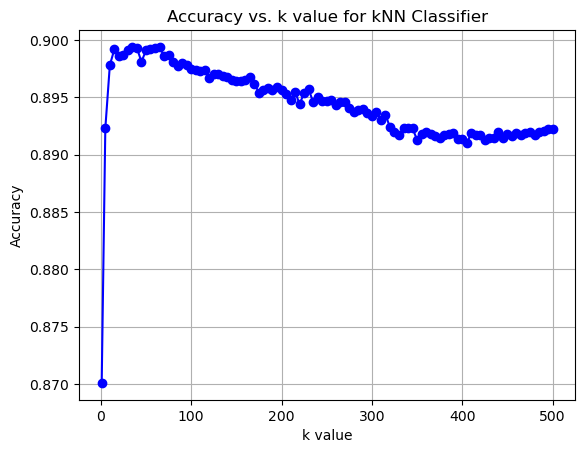

In [42]:
import matplotlib.pyplot as plt

k_values = list(accuracy_map.keys())
accuracies = list(accuracy_map.values())

# Plotting the line chart
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Accuracy vs. k value for kNN Classifier')
plt.xlabel('k value')
plt.ylabel('Accuracy')

# Display the plot
plt.grid(True)
plt.show()

In [45]:
best_k, best_acc = max(accuracy_map.items(), key=lambda x: x[1])

In [47]:
print(f"optimal k: {best_k} | accuracy: {best_acc}")

optimal k: 35 | accuracy: 0.8994


### Tuning for best stratified fold


In [50]:
stratified_accuracy_map = {}

for split in range(2, 20):
    knn = KNeighborsClassifier(n_neighbors=35, algorithm='auto')
    skf = StratifiedKFold(n_splits=split, shuffle=True)
    scores = cross_val_score(knn, X_scaled, y_all, cv=skf, scoring='accuracy')
    accuracy = round(np.mean(scores), 4)
    stratified_accuracy_map[split] = accuracy
    print(f"Processed split value: {split} | Accuracy: {accuracy}")


Processed split value: 2 | Accuracy: 0.898
Processed split value: 3 | Accuracy: 0.8985
Processed split value: 4 | Accuracy: 0.8994
Processed split value: 5 | Accuracy: 0.8984
Processed split value: 6 | Accuracy: 0.8991
Processed split value: 7 | Accuracy: 0.8993
Processed split value: 8 | Accuracy: 0.8995
Processed split value: 9 | Accuracy: 0.8987
Processed split value: 10 | Accuracy: 0.8993
Processed split value: 11 | Accuracy: 0.8993
Processed split value: 12 | Accuracy: 0.8989
Processed split value: 13 | Accuracy: 0.8991
Processed split value: 14 | Accuracy: 0.8994
Processed split value: 15 | Accuracy: 0.8998
Processed split value: 16 | Accuracy: 0.8995
Processed split value: 17 | Accuracy: 0.8999
Processed split value: 18 | Accuracy: 0.8994
Processed split value: 19 | Accuracy: 0.8995


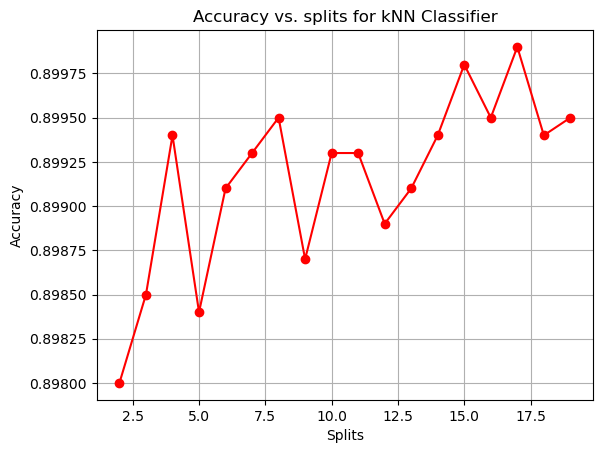

In [51]:
split_values = list(stratified_accuracy_map.keys())
split_accuracies = list(stratified_accuracy_map.values())

# Plotting the line chart
plt.plot(split_values, split_accuracies, marker='o', linestyle='-', color='r')

# Adding titles and labels
plt.title('Accuracy vs. splits for kNN Classifier')
plt.xlabel('Splits')
plt.ylabel('Accuracy')

# Display the plot
plt.grid(True)
plt.show()

In [52]:
best_split, best_split_acc = max(stratified_accuracy_map.items(), key=lambda x: x[1])

In [53]:
print(f"optimal split: {best_split} | accuracy: {best_split_acc}")

optimal split: 17 | accuracy: 0.8999
